In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as stats
import statsmodels.api as sm  

In [56]:
data = pd.read_csv('starts.csv')
regions = pd.read_csv('regions.csv')

In [57]:
data = data[data['finish_time'] < 3600]
data = data[data['athlete_age'] < 80]

In [58]:
#merging tables and removing duplicates
data = data.merge(regions, on='region', how='left')
unique_runners = data.drop_duplicates(subset=['region', 'athlete_id'])

In [28]:
unique_runners.shape

(37432, 93)

In [29]:

unique_runners.athlete_id.nunique()

31556

~ 6 тысяч бегали в более чем одном регионе

In [59]:
#share of newbies by regions
newbie_ratios = (
    unique_runners
    .groupby('region', as_index=False)
    .agg(newbie_ratio=('is_newbie', lambda x: x.sum() / len(x)))
)

Проверим распределение на нормальность

<Axes: xlabel='newbie_ratio', ylabel='Count'>

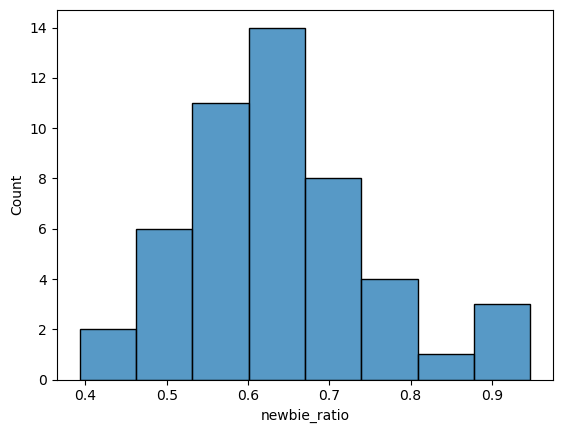

In [31]:
sns.histplot(newbie_ratios.newbie_ratio)

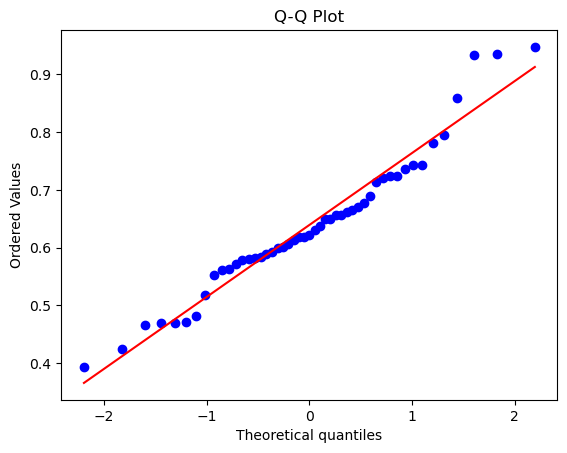

In [32]:
stats.probplot(newbie_ratios.newbie_ratio, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

Все отлично за исключением хвоста в конце

In [33]:
stats.shapiro(newbie_ratios.newbie_ratio)

ShapiroResult(statistic=0.9575956463813782, pvalue=0.07543288171291351)

Можем считать распределение нормальным

In [34]:
# ДАЛЕЕ МАКСИМ делает

newbie_ratios.head(2)

,region,newbie_ratio
0,Архангельская область,0.781250
1,Астраханская область,0.723926


In [60]:
reg = newbie_ratios.merge(regions, how='left', on='region')
print(reg.shape[0])
display(reg.head(2))

49


,region,newbie_ratio,per_capita_income_rub,median_income_per_capita_rub,milk_consumption_per_capita,sugar_consumption_per_capita,urban_population_pct,male_to_female_ratio,under_working_age_population_pct,working_age_population_pct,...,disabled_population_per_1000,population_total,crimes_murder_attempts,crimes_grievous_bodily_harm,crimes_robbery,crimes_armed_robbery,crimes_hooliganism,crimes_drug_related,nominal_wages_avg_rub,poverty_rate_pct_region
0,Архангельская область,0.781250,48356,35748.2,206.0,40.0,77.7,1162.0,18.1,55.3,...,79.0,1016.0,116,178,471,47,10,1109,67835,11.8
1,Астраханская область,0.723926,31119,25038.0,200.0,44.0,64.1,1129.0,21.2,56.3,...,47.2,957.8,29,93,147,19,13,1135,47780,13.8


Далее я хочу удалить не стат значимые (p_value > 0.05) корреляции с newbie_ratio.

In [65]:
# Фильтруем только целочисленные столбцы  
integer_columns = reg.select_dtypes(include=['number']).columns  

# Переменная для хранения незначимых переменных  
insignificant_vars = []  

# Обходим все целочисленные столбцы  
for col in integer_columns:  
    
    try:
        if col != 'newbie_ratio':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Пирсона и p-значение  
            corr, p_value = stats.pearsonr(reg[col], reg['newbie_ratio'])  
        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))

Nan по milk_production_total столбцу есть
Nan по milk_production_per_cow столбцу есть
Nan по substance_abuse_patients_per_100k столбцу есть

Неподходящие целочисленные переменные: ['per_capita_income_rub', 'median_income_per_capita_rub', 'milk_consumption_per_capita', 'sugar_consumption_per_capita', 'urban_population_pct', 'male_to_female_ratio', 'under_working_age_population_pct', 'working_age_population_pct', 'above_working_age_population_pct', 'dependency_ratio', 'birth_rate_per_1000', 'death_rate_per_1000', 'infant_mortality_per_1000_births', 'natural_increase_rate_per_1000', 'marriage_rate_per_1000', 'divorce_rate_per_1000', 'migration_increase_rate_per_10000', 'library_books_per_1000', 'library_users_total', 'forest_coverage_pct', 'disease_incidence_infectious', 'disease_incidence_cancer', 'disease_incidence_blood', 'disease_incidence_endocrine', 'disease_incidence_nervous', 'disease_incidence_eye', 'disease_incidence_ear', 'disease_incidence_circulatory', 'disease_incidence_resp

Вышло, что по 3 столбцам есть Nan и в 66 столбцах незначимая корреляция с newbie_ratio

In [66]:
# Удаляем незначимые переменные (по корреляции) из датафрейма  
reg = reg.drop(columns=insignificant_vars)  


In [ ]:
reg.head(3)
# теперь все выглядит так

,region,newbie_ratio,milk_production_total,milk_production_per_cow,disease_incidence_musculoskeletal,substance_abuse_patients_per_100k
0,Архангельская область,0.781250,141.155,7798.0,43.1,NaN
1,Астраханская область,0.723926,178.222,1712.0,35.9,0.2
2,Белгородская область,0.584507,721.776,8543.0,30.8,0.5


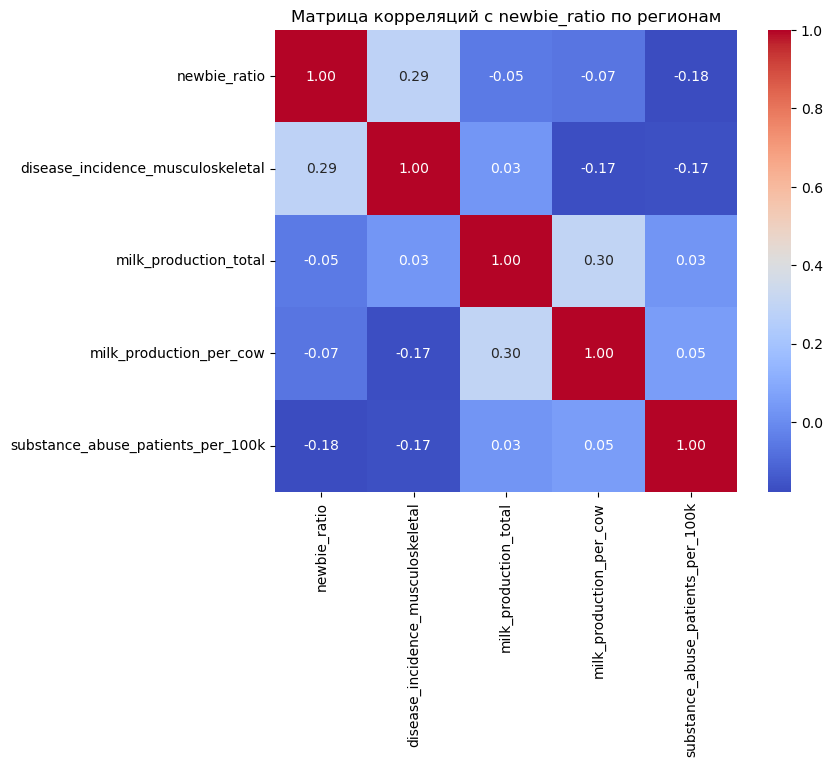

In [69]:
target = 'newbie_ratio'
numeric_df = reg.select_dtypes(include=['float64', 'int64'])  
  
correlation_with_target = numeric_df.corr()[target].sort_values(ascending=False)  

filtered_features = correlation_with_target[abs(correlation_with_target) >= 0.001].index.tolist()  
correlation_matrix = numeric_df[filtered_features].corr()  

plt.figure(figsize=(8, 6))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)  
plt.title('Матрица корреляций с newbie_ratio по регионам')  
plt.show()

# ОТОБРАЗИМ ТОЛЬКО ТЕ ПЕРЕМЕННЫЕ КОТОРЫЕ ПО КОРР >= 0.2

Cто процентов у нас эти 3 столбца где Nanы есть, будут также не стат значимую корреляцию иметь с Newbie_ratio, поэтому остается ТОЛЬКО ОДИН столбец стат начимо коррелирующий с newbie_ratio и это disease_incidence_musculoskeletal

In [73]:
coef, p_value = stats.pearsonr(reg['newbie_ratio'], reg['disease_incidence_musculoskeletal'])
print(coef, p_value)          

0.28508298469382387 0.047091304436539645


Щас сделаю по корреляции спирмена


In [97]:
# return к исходным данным для подсчета уже корр спирмена
data = pd.read_csv('starts.csv')
regions = pd.read_csv('regions.csv')
data = data[data['finish_time'] < 3600]
data = data[data['athlete_age'] < 80]
data = data.merge(regions, on='region', how='left')
unique_runners = data.drop_duplicates(subset=['region', 'athlete_id'])
newbie_ratios = (
    unique_runners
    .groupby('region', as_index=False)
    .agg(newbie_ratio=('is_newbie', lambda x: x.sum() / len(x)))
)
reg = newbie_ratios.merge(regions, how='left', on='region')

In [99]:
reg['air_pollutant_relative_per_1000_person'] = reg['air_pollutant_emissions'] / reg['population_total'] * 1000
reg = reg.drop(columns=['air_pollutant_emissions'])
#относительно на 1000 человек считаем

In [100]:
# Фильтруем только целочисленные столбцы  
integer_columns = reg.select_dtypes(include=['number']).columns  

# Переменная для хранения незначимых переменных  
insignificant_vars = []  

# Обходим все целочисленные столбцы  
for col in integer_columns:  
    
    try:
        if col != 'newbie_ratio':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Пирсона и p-значение  
            corr, p_value = stats.spearmanr(reg[col], reg['newbie_ratio'])  
        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))


Неподходящие целочисленные переменные: ['per_capita_income_rub', 'median_income_per_capita_rub', 'milk_consumption_per_capita', 'sugar_consumption_per_capita', 'urban_population_pct', 'under_working_age_population_pct', 'working_age_population_pct', 'dependency_ratio', 'death_rate_per_1000', 'infant_mortality_per_1000_births', 'natural_increase_rate_per_1000', 'marriage_rate_per_1000', 'migration_increase_rate_per_10000', 'library_books_per_1000', 'library_users_total', 'forest_coverage_pct', 'disease_incidence_infectious', 'disease_incidence_cancer', 'disease_incidence_blood', 'disease_incidence_endocrine', 'disease_incidence_nervous', 'disease_incidence_eye', 'disease_incidence_ear', 'disease_incidence_circulatory', 'disease_incidence_respiratory', 'disease_incidence_digestive', 'disease_incidence_skin', 'disease_incidence_musculoskeletal', 'disease_incidence_genitourinary', 'disease_incidence_congenital', 'disease_incidence_trauma', 'disease_incidence_all', 'captured_air_pollutants

In [101]:
# Удаляем незначимые переменные (по корреляции) из датафрейма  
reg = reg.drop(columns=insignificant_vars)  


Итого у нас удалилось 62 столбца с не стат значимой корреляцией с Newbie_ratio


In [102]:
reg.head(3)
print(reg.columns)


Index(['region', 'newbie_ratio', 'male_to_female_ratio',
       'above_working_age_population_pct', 'birth_rate_per_1000',
       'divorce_rate_per_1000', 'milk_production_total',
       'milk_production_per_cow', 'substance_abuse_patients_per_100k',
       'air_pollutant_relative_per_1000_person'],
      dtype='object')


Посмотрим на корреляции стат значимых переменных влиящие на newbie_ratio

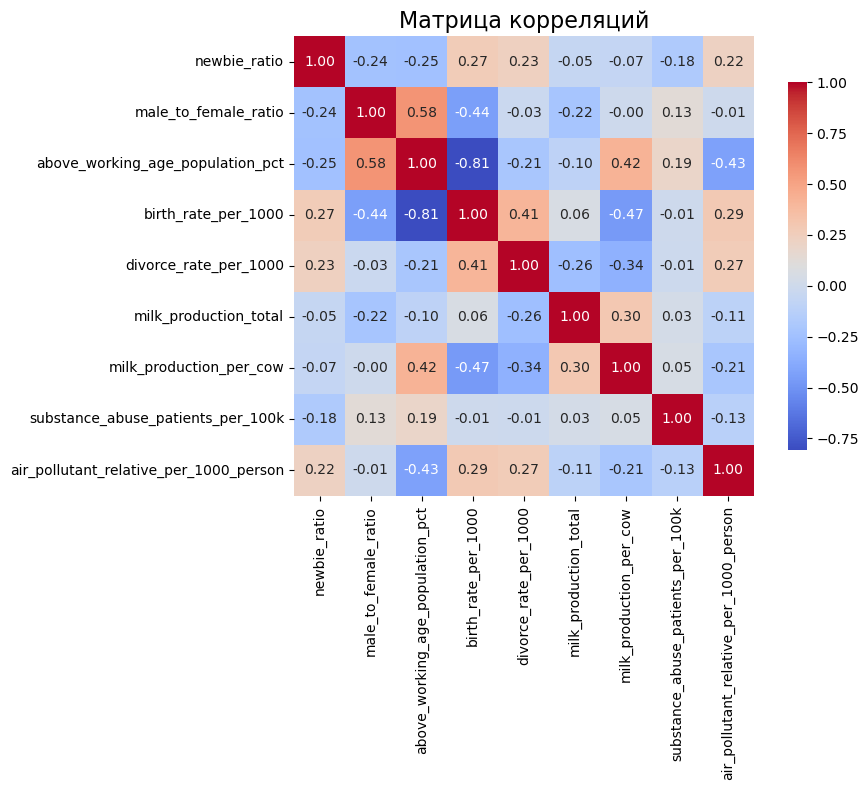

In [103]:
reg_numeric = reg.drop(columns=['region'])  

# Расчет матрицы корреляций  
correlation_matrix = reg_numeric.corr()  

# Настройки визуализации  
plt.figure(figsize=(10, 8))  # Установка размера графика  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})  

# Добавление заголовка  
plt.title('Матрица корреляций', fontsize=16)  
plt.tight_layout()  # Уплотняем график  
plt.show()  

In [ ]:
reg.isnull().sum()


region                               0
newbie_ratio                         0
male_to_female_ratio                 0
above_working_age_population_pct     0
birth_rate_per_1000                  0
divorce_rate_per_1000                0
milk_production_total                1
milk_production_per_cow              1
air_pollutant_emissions              0
substance_abuse_patients_per_100k    1
dtype: int64

In [ ]:
reg[reg['milk_production_total'].isnull()]  # по питеру нет о кол ве произведенного молока

,region,newbie_ratio,male_to_female_ratio,above_working_age_population_pct,birth_rate_per_1000,divorce_rate_per_1000,milk_production_total,milk_production_per_cow,air_pollutant_emissions,substance_abuse_patients_per_100k
36,Санкт-Петербург,0.581375,1217.0,25.5,9.0,4.8,NaN,NaN,70,1.3


In [ ]:
reg[reg['substance_abuse_patients_per_100k'].isnull()] #Контингенты пациентов с токсикоманией NAN в архангельской области

,region,newbie_ratio,male_to_female_ratio,above_working_age_population_pct,birth_rate_per_1000,divorce_rate_per_1000,milk_production_total,milk_production_per_cow,air_pollutant_emissions,substance_abuse_patients_per_100k
0,Архангельская область,0.78125,1162.0,26.6,8.1,5.1,141.155,7798.0,206,NaN


In [ ]:
reg[reg['milk_production_per_cow'].isnull()] # опять в питере NAN по производству молока одной коровой 

,region,newbie_ratio,male_to_female_ratio,above_working_age_population_pct,birth_rate_per_1000,divorce_rate_per_1000,milk_production_total,milk_production_per_cow,air_pollutant_emissions,substance_abuse_patients_per_100k
36,Санкт-Петербург,0.581375,1217.0,25.5,9.0,4.8,NaN,NaN,70,1.3


в питере по молоку nan потому что, цитата из описания БД: "Производство молока (и надой молока на корову), в хозяйствах всех 
категорий. Значение показателя для 
Ленинградской области включает
г. Санкт-Петербург."

In [106]:
data[data.region == 'Ленинградская область'].city.value_counts()

city
Гатчина    599
Кудрово    572
Name: count, dtype: int64